In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

#### ETF Filter

In [2]:
etf_df = pd.read_csv('ETF_Screen_Information.csv')

etfs = etf_df.ETF_Ticker.unique()
print("number of etfs: {}".format(len(etfs)))

etf_df.head()

number of etfs: 600


Date ETF_Ticker  Average Spread  AUM  Count  Div Yield  \
0  2002-12-31       *CGR             NaN  NaN    NaN        NaN   
1  2002-12-31       *CWW             NaN  NaN    NaN        NaN   
2  2002-12-31       *XAW             NaN  NaN    NaN        NaN   
3  2002-12-31     *XAW.U             NaN  NaN    NaN        NaN   
4  2002-12-31       *XBM             NaN  NaN    NaN        NaN   

   Price to Book  Price to Earnings  Total Return  Dollar Volume  ETF Price  
0            NaN                NaN           NaN            NaN        NaN  
1            NaN                NaN           NaN            NaN        NaN  
2            NaN                NaN           NaN            NaN        NaN  
3            NaN                NaN           NaN            NaN        NaN  
4            NaN                NaN           NaN            NaN        NaN

In [3]:
etf_df.Date = pd.to_datetime(etf_df.Date)
etf_df.index = etf_df.Date
etf_df.drop('Date', axis=1, inplace=True)

In [4]:
etf_df.groupby(etf_df['ETF_Ticker']).count()

Average Spread   AUM  Count  Div Yield  Price to Book  \
ETF_Ticker                                                          
*CGR                     0  3624   3538       3538           3538   
*CWW                     0  3933   3790       3790           3790   
*XAW                     0  2004   1916          0              0   
*XAW.U                   0   788   1916          0              0   
*XBM                     0  2965   2953       2953           2953   
...                    ...   ...    ...        ...            ...   
WOOD                  2219  3680   3677       3677           3677   
WPS                   2219  3908   3885       3885           3885   
XJH                    595   597    592        592            592   
XJR                    595   597    592        592            592   
XVV                    584   597    568        568            568   

            Price to Earnings  Total Return  Dollar Volume  ETF Price  
ETF_Ticker                                                             
*CGR                     3539          3626              0       3626  
*CWW                     3791          3935              0       3935  
*XAW                        0          2006              0       2002  
*XAW.U                      0           828              0        824  
*XBM                     2954          2967              0       2963  
...                       ...           ...            ...        ...  
WOOD                     3677          3681           2270       3680  
WPS                      3885          3909           2235       3905  
XJH                       592           598            581        596  
XJR                       592           598            572        596  
XVV                       568           598            581        596  

[600 rows x 9 columns]

In [5]:
count_df = etf_df.groupby(['ETF_Ticker']).agg({'Count':['min','max']})
count_df.columns = count_df.columns.droplevel()
count_df = count_df.reset_index(drop=False)

# remove tickers with less than 10 stocks
remove_tickers = count_df[(count_df['min']<10) & (count_df['max']<10)]
print("{} of tickers should be removed as they consists of very few stocks".format(len(remove_tickers)))
display(remove_tickers)

# check tickers with large changes in number of stocks
check_tickers = count_df[(count_df['min']<10) & (count_df['max']>10)]
print("{} of tickers have large changes in the number of stocks".format(len(check_tickers)))
display(check_tickers)

28 of tickers should be removed as they consists of very few stocks


ETF_Ticker  min  max
2         *XAW  5.0  8.0
3       *XAW.U  5.0  8.0
5         *XCD  1.0  4.0
7         *XCH  1.0  3.0
21        *XEC  1.0  3.0
26        *XEH  1.0  3.0
28        *XEM  1.0  3.0
31        *XFH  1.0  3.0
34        *XGI  1.0  4.0
36        *XHC  1.0  4.0
38        *XID  1.0  3.0
39        *XIN  1.0  4.0
43        *XMC  1.0  3.0
44      *XMC.U  1.0  3.0
46        *XMH  1.0  4.0
50        *XSP  1.0  4.0
52        *XSU  1.0  4.0
53        *XUH  1.0  3.0
69        1657  5.0  6.0
475       HAWX  2.0  4.0
476       HEEM  1.0  5.0
477       HEFA  2.0  4.0
478       HEWC  2.0  4.0
479       HEWG  1.0  4.0
480       HEWJ  2.0  4.0
481       HEWU  2.0  4.0
482       HEZU  2.0  4.0
483       HSCZ  2.0  4.0

26 of tickers have large changes in the number of stocks


ETF_Ticker  min     max
23        *XEF  2.0  2668.0
24      *XEF.U  2.0  2668.0
40        *XIT  5.0    28.0
47        *XRE  8.0    22.0
54        *XUS  1.0   509.0
55      *XUS.U  1.0   509.0
57        *XUU  4.0   118.0
58      *XUU.U  4.0   118.0
59        *XWD  4.0  1553.0
150     B2QWDR  1.0  1346.0
325     BLFJXN  7.0   912.0
351     BMXR0V  1.0    43.0
353     BMXR0X  1.0    55.0
354     BMXR0Y  2.0    81.0
395     BRHZ03  1.0    47.0
426        EEM  8.0  1252.0
433        EFV  2.0   617.0
439       ENOR  2.0    75.0
446        EWA  2.0   100.0
462        EWS  1.0    43.0
467        EWY  1.0   121.0
473       FILL  1.0   291.0
496       IEMG  1.0  2705.0
500        IEV  3.0   375.0
503        IGE  2.0   159.0
599        XVV  1.0   463.0

In [6]:
etf_df = etf_df[~etf_df['ETF_Ticker'].isin(remove_tickers['ETF_Ticker'])]

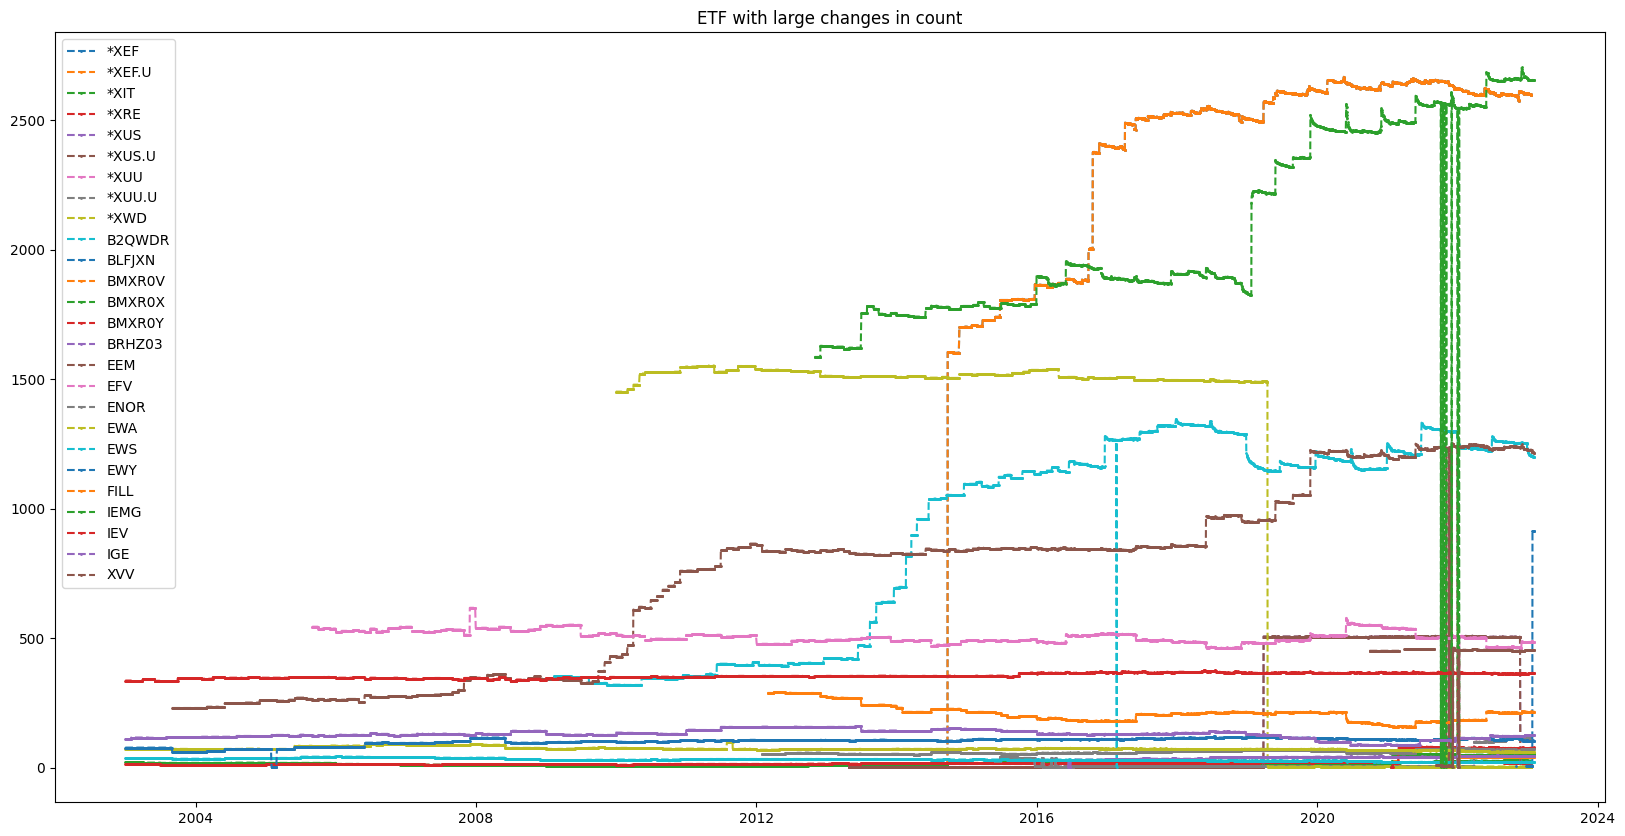

In [7]:
count_df = etf_df[etf_df['ETF_Ticker'].isin(check_tickers.ETF_Ticker)][['ETF_Ticker','Count']]
count_df = count_df.pivot(columns='ETF_Ticker',values='Count')
# the plot below shows the large changes of number of stocks is more likely caused by data cleaness; hence, it might not be necessary to remove
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(count_df,'o--',markersize=1)
plt.title('ETF with large changes in count')
plt.legend(count_df.columns)
plt.show()

In [8]:
# remove tickers with insufficient data
count_df = etf_df.groupby(['ETF_Ticker']).agg({'Total Return':'count'})/255
count_df = count_df.reset_index(drop=False)
remove_tickers = count_df[count_df['Total Return']<1]
print("{} of tickers should be removed as they does not have sufficiently long trading period".format(len(remove_tickers)))
display(remove_tickers)

36 of tickers should be removed as they does not have sufficiently long trading period


ETF_Ticker  Total Return
4        *XCLN      0.776471
12       *XDNA      0.772549
26       *XHAK      0.776471
55        2851      0.654902
56        2852      0.694118
277     BJ5JP4      0.478431
278     BJ5JP6      0.478431
279     BJ5JP7      0.478431
304     BL6JW6      0.815686
306     BLFJXN      0.368627
310     BM9F7X      0.117647
313     BMFFMS      0.486275
314     BMFFMT      0.486275
315     BMFV6F      0.827451
317     BMG7FM      0.000000
323     BMHS9T      0.909804
327     BMTPP8      0.815686
328     BMVM9Y      0.815686
346     BN4FDN      0.447059
351     BN7J6F      0.654902
352     BN7T53      0.537255
354     BNGHWV      0.600000
355     BNGHWW      0.752941
356     BNGHWX      0.760784
358     BNGJDY      0.478431
361     BNZGC3      0.000000
365     BP6L8Q      0.000000
366     BP6L8R      0.000000
367     BP6L8Z      0.682353
368     BPQ01K      0.000000
369     BPX4LP      0.223529
370     BQ7XHR      0.521569
413       EFRA      0.258824
459       IBLC      0.776471
460       IBRN      0.447059
509       IVEG      0.776471

In [9]:
etf_df = etf_df[~etf_df['ETF_Ticker'].isin(remove_tickers['ETF_Ticker'])]

In [10]:
print("Number of tickers after ETF filter: {}".format(len(etf_df['ETF_Ticker'].unique())))

Number of tickers after ETF filter: 536


In [14]:
etf_df = pd.read_csv('ETF_Screen_Information_2023_02_09.csv', index_col=0)

etfs = etf_df.ETF_Ticker.unique()
print("number of etfs: {}".format(len(etfs)))

etf_df.Date = pd.to_datetime(etf_df.Date)
etf_df.index = etf_df.Date
etf_df.drop('Date', axis=1, inplace=True)

etf_df.head()

number of etfs: 203


ETF_Ticker  Average Spread           AUM  Count  Div Yield  \
Date                                                                    
2008-01-02       *XCS             NaN  2.792085e+07  217.0   0.039010   
2008-01-02       *XEG             NaN  5.492800e+08   61.0   0.024876   
2008-01-02       *XFN             NaN  5.332795e+08   29.0   0.028454   
2008-01-02       *XGD             NaN  1.125968e+09   37.0   0.005080   
2008-01-02       *XIC             NaN  4.839745e+08  259.0   0.021631   

            Price to Book  Price to Earnings  Total Return  Dollar Volume  \
Date                                                                        
2008-01-02       1.761031          59.699048     18.435817            NaN   
2008-01-02       2.924148          20.516180     26.531370            NaN   
2008-01-02       2.183175          13.263941     30.330787            NaN   
2008-01-02       2.517170         144.230461     20.947008            NaN   
2008-01-02       2.586234          19.966194     27.812710            NaN   

            ETF Price  
Date                   
2008-01-02  17.467957  
2008-01-02  22.252901  
2008-01-02  26.252596  
2008-01-02  19.519732  
2008-01-02  22.083185

### Pair Filter

In [15]:
etfs = list(etf_df['ETF_Ticker'].unique())

In [16]:
def pair_analysis(df, index1, index2, plot=True):

    output = {}

    # calculate number of zero crosses
    p1 = np.log(etf_df[etf_df['ETF_Ticker']==index1]['Total Return'])
    p2 = np.log(etf_df[etf_df['ETF_Ticker']==index2]['Total Return'])

    X = pd.concat([p1, p2], axis=1).dropna()
    X.replace(to_replace=0, method='ffill')
    X.columns = ['Price 1', 'Price 2']
    y = X['Price 1']
    X = X.drop('Price 1',axis=1)

    X = sm.add_constant(X)
    result = sm.OLS(y, X).fit()
    output['const'] = [np.round(result.params[0], 4)]
    output['beta'] = [np.round(result.params[1], 4)]

    if plot:
        plt.rcParams["figure.figsize"] = (20,5)

        fig, axs = plt.subplots(1, 2)

        axs[0].plot(np.exp(X @ result.params))
        axs[0].plot(np.exp(y))
        axs[0].set_title("Scaled Price: {} vs {}".format(index2, index1))
        axs[0].legend([index2, index1])

        axs[1].plot(result.resid)
        axs[1].hlines(0,result.resid.index.min(), result.resid.index.max(), colors='r')
        axs[1].set_title("Residues: {} vs {}".format(index2, index1))

        plt.show()

    trade_period = len(result.resid)
    n_zero_cross = np.nansum(result.resid.rolling(2).apply(lambda x: 1 if np.sign(x[1]) != np.sign(x[0]) else 0))
    output['trade_period'] = [trade_period]
    output['n_zero_cross'] = [int(n_zero_cross)]

    # calculate liquidity measure: market effective coefficient
    p1 = p1.dropna() 
    p2 = p2.dropna()
    def mrk_eff_cal(p1):
        d_ret = p1 - p1.shift(1)
        m_ret = p1 - p1.shift(20)
        mrk_eff_coef = np.var(m_ret.dropna())/(20*np.var(d_ret.dropna()))
        return mrk_eff_coef
    output['mrk_eff_coef_1'] = [np.round(mrk_eff_cal(p1), 4)]
    output['mrk_eff_coef_2'] = [np.round(mrk_eff_cal(p2), 4)]

    # calculate similarity of 2 indices
    params = ['Price to Book', 'Price to Earnings', 'Div Yield']
    for p in params:
        df1 = etf_df[etf_df['ETF_Ticker']==index1][p]
        df2 = etf_df[etf_df['ETF_Ticker']==index2][p]
        df12 = pd.concat([df1, df2], axis=1).dropna()
        df12.columns = [p + ' 1', p + ' 2']
        output[p + ' 1'] = [np.round(np.std(df12[p + ' 1']),4)]
        output[p + ' 2'] = [np.round(np.std(df12[p + ' 2']),4)]
        output[p + ' Corr'] = [np.round(df12[p + ' 1'].corr(df12[p + ' 2']),4)]

    # calculate spread volatility of 2 indices
    df1 = etf_df[etf_df['ETF_Ticker']==index1]['Average Spread']
    df2 = etf_df[etf_df['ETF_Ticker']==index2]['Average Spread']
    df12 = pd.concat([df1, df2], axis=1).dropna()
    df12.columns = ['Average Spread' + ' 1', 'Average Spread' + ' 2']
    output['Average Spread 1'] = [np.std(df12['Average Spread 1'])]
    output['Average Spread 2'] = [np.std(df12['Average Spread 2'])]

    # calculate mean dollar volume, aum
    params = ['AUM', 'Dollar Volume']
    for p in params:
        df1 = etf_df[etf_df['ETF_Ticker']==index1][p]
        df2 = etf_df[etf_df['ETF_Ticker']==index2][p]
        df12 = pd.concat([df1, df2], axis=1).dropna()
        df12.columns = [p + ' 1', p + ' 2']

        output[p + ' 1'] = [np.round(df12[p+' 1'].mean(),4)]
        output[p + ' 2'] = [df12[p+' 2'].mean()]

        if df12[p+' 1'].mean() == 0:
            output[p + ' ratio'] = [index1 + " 0"]
        elif df12[p+' 2'].mean() == 0:
            output[p + ' ratio'] = [index2 + " 0"]
        else:
            volume_ratio = df12[p+' 1'].mean()/df12[p+' 2'].mean()
            output[p + ' ratio'] = [np.round(volume_ratio, 4)]

    output = pd.DataFrame.from_dict(output)
    output.index = pd.MultiIndex.from_tuples([(index1, index2)], names=["index 1", "index 2"])
    output

    return output


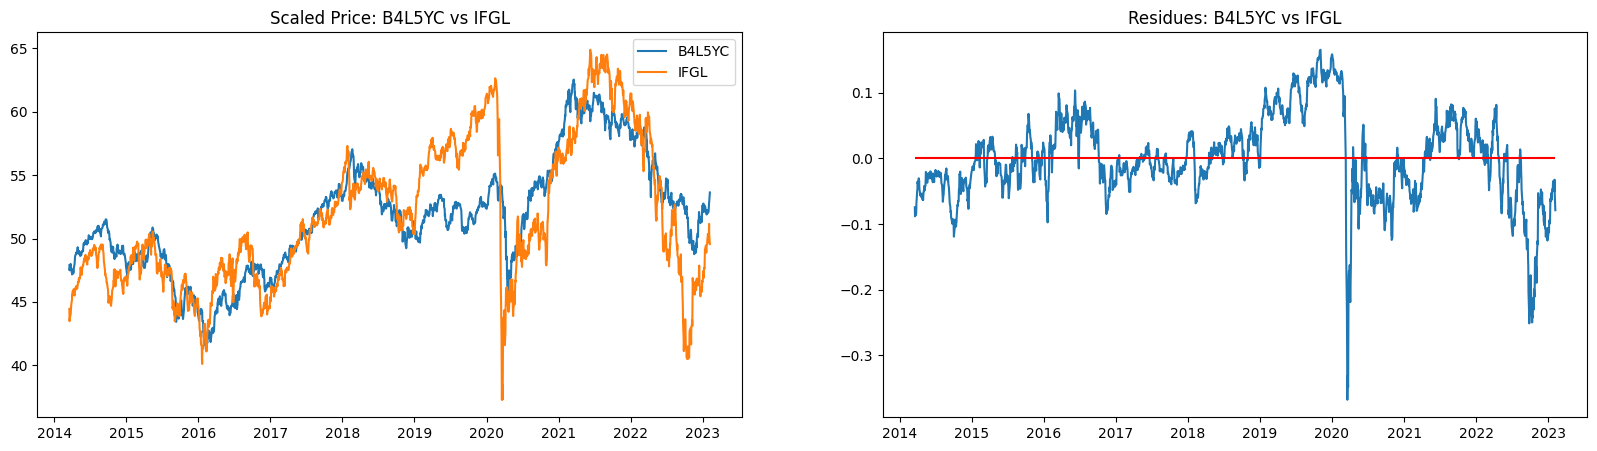

const   beta  trade_period  n_zero_cross  mrk_eff_coef_1  \
index 1 index 2                                                              
IFGL    B4L5YC   2.1927  0.503          2238           104          0.0808   

                 mrk_eff_coef_2  Price to Book 1  Price to Book 2  \
index 1 index 2                                                     
IFGL    B4L5YC           0.0599           0.1073           0.2161   

                 Price to Book Corr  Price to Earnings 1  ...  Div Yield 2  \
index 1 index 2                                           ...                
IFGL    B4L5YC              -0.1141                4.706  ...        0.003   

                 Div Yield Corr  Average Spread 1  Average Spread 2  \
index 1 index 2                                                       
IFGL    B4L5YC           0.4465               NaN               NaN   

                        AUM 1         AUM 2  AUM ratio  Dollar Volume 1  \
index 1 index 2                                                           
IFGL    B4L5YC   5.022535e+08  7.556140e+08     0.6647              NaN   

                 Dollar Volume 2  Dollar Volume ratio  
index 1 index 2                                        
IFGL    B4L5YC               NaN                  NaN  

[1 rows x 23 columns]

In [17]:
index1 = etfs[100]
index2 = etfs[200]
output = pair_analysis(etf_df, index1, index2, plot=True)
output

In [20]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()

In [21]:
num_cores

4

In [25]:
def calculate_pair_analysis(i, etf_df, etfs):
    output_df = pd.DataFrame()    
    for j in range(i+1, len(etfs)):
        try:
            output = pair_analysis(etf_df, etfs[i], etfs[j], plot=False)
            output_df = pd.concat([output_df, output], axis=0)
        except Exception as e:
            print(etfs[i], etfs[j])
            print(e)
    return output_df

In [28]:
len(etfs)

203

In [43]:
processed_list = Parallel(n_jobs=num_cores)(delayed(calculate_pair_analysis)(i, etf_df, etfs) for i in range(len(etfs)))

/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site

In [44]:
output_all = pd.concat(processed_list)

In [46]:
output_all.to_csv("Pairs_Screen_Measures.csv")

In [47]:
output_all['percent_zero_cross'] = output_all['n_zero_cross']/output_all['trade_period']

In [72]:
# spread data and dollar volume data is missing for some pairs
output_all.notna().sum()

const                     20503
beta                      20503
trade_period              20503
n_zero_cross              20503
mrk_eff_coef_1            20503
mrk_eff_coef_2            20503
Price to Book 1           20503
Price to Book 2           20503
Price to Book Corr        20503
Price to Earnings 1       20503
Price to Earnings 2       20503
Price to Earnings Corr    20503
Div Yield 1               20503
Div Yield 2               20503
Div Yield Corr            20503
Average Spread 1           7140
Average Spread 2           7140
AUM 1                     20503
AUM 2                     20503
AUM ratio                 20503
Dollar Volume 1            7140
Dollar Volume 2            7140
Dollar Volume ratio        7140
percent_zero_cross        20503
dtype: int64

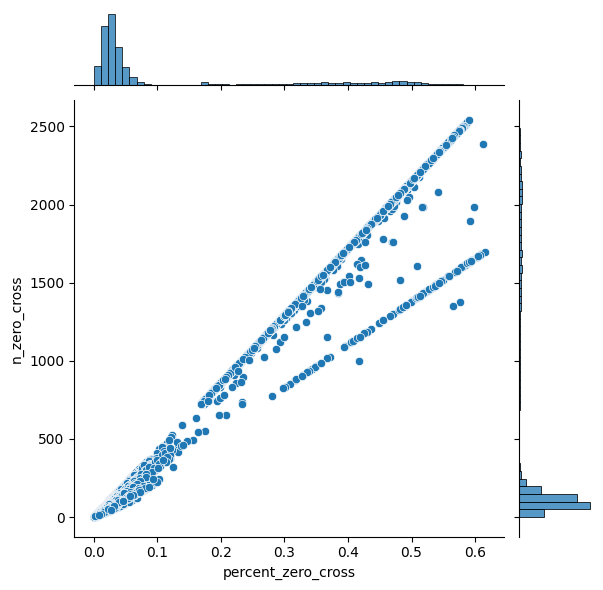

In [53]:
import seaborn as sns
sns.jointplot(data=output_all, x="percent_zero_cross", y="n_zero_cross")
plt.show()

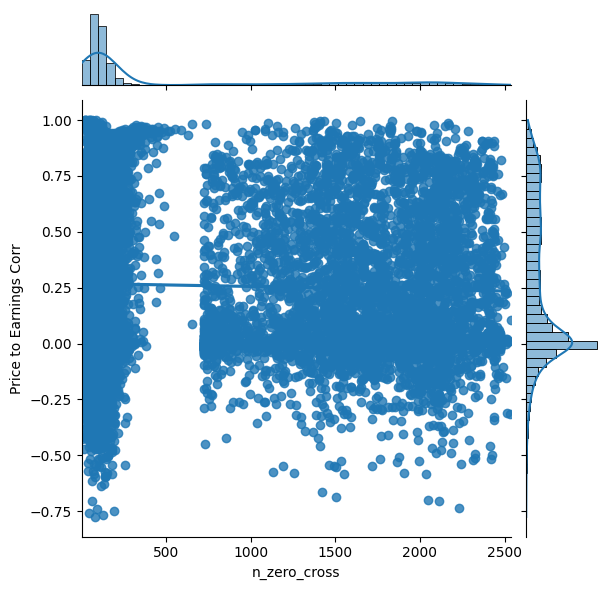

In [79]:
sns.jointplot(data=output_all, x="n_zero_cross", y="Price to Earnings Corr", kind='reg')
plt.show()

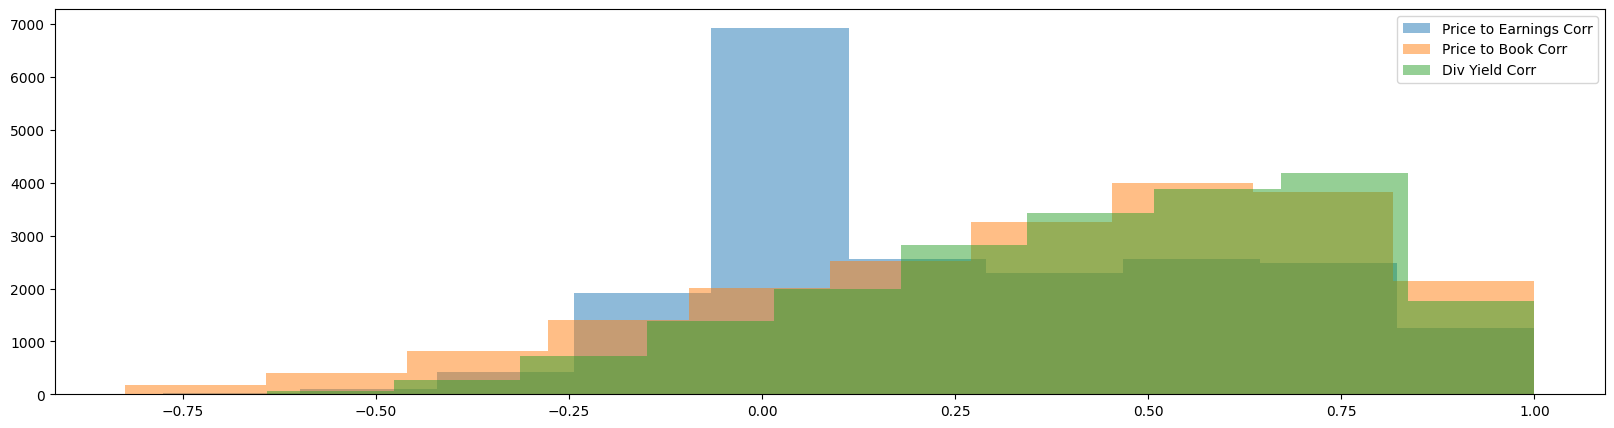

In [78]:
plt.hist(output_all['Price to Earnings Corr'], alpha=0.5)
plt.hist(output_all['Price to Book Corr'], alpha=0.5)
plt.hist(output_all['Div Yield Corr'], alpha=0.5)
plt.legend(['Price to Earnings Corr', 'Price to Book Corr', 'Div Yield Corr'])
plt.show()

In [75]:
# Regression results shows it is statistically significant for more similar pairs to have more cross overs
X = output_all[['Price to Earnings Corr', 'Price to Book Corr', 'Div Yield Corr']]
y = output_all['percent_zero_cross']
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percent_zero_cross   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.603
Date:                Fri, 10 Feb 2023   Prob (F-statistic):             0.0179
Time:                        00:44:40   Log-Likelihood:                 7064.7
No. Observations:               20503   AIC:                        -1.413e+04
Df Residuals:                   20501   BIC:                        -1.411e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1273      0.002     83.531      0.000       0.124       0.130
Price to Earnings Corr    -0.0085      0.004     -2.367      0.018      -0.016      -0.001
==============================================================================
Omnibus:                     3872.061   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6559.152
Skew:                           1.380   Prob(JB):                         0.00
Kurtosis:                       3.254   Cond. No.                         3.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

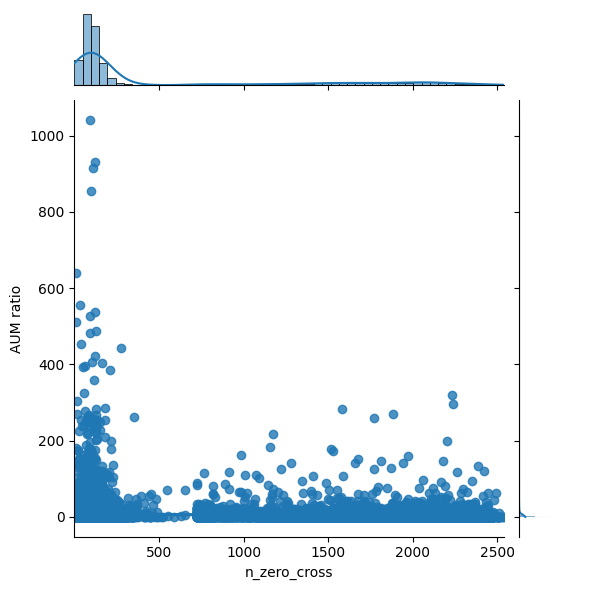

In [81]:
sns.jointplot(data=output_all, x="n_zero_cross", y="AUM ratio", kind='reg')
plt.show()

In [84]:
X = output_all[['AUM ratio']]
y = output_all['percent_zero_cross']
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percent_zero_cross   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.26
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           3.27e-05
Time:                        00:52:36   Log-Likelihood:                 7070.6
No. Observations:               20503   AIC:                        -1.414e+04
Df Residuals:                   20501   BIC:                        -1.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1263      0.001    102.670      0.000       0.124       0.129
AUM ratio     -0.0002   4.67e-05     -4.155      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     3872.804   Durbin-Watson:                   0.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6561.468
Skew:                           1.380   Prob(JB):                         0.00
Kurtosis:                       3.253   Cond. No.                         27.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

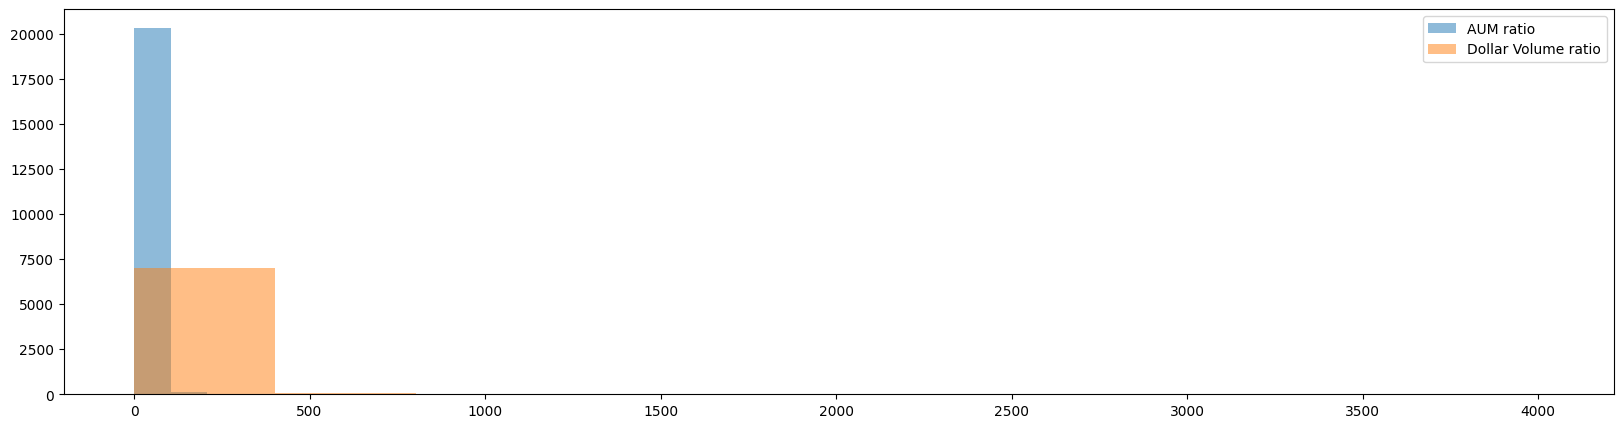

In [80]:
plt.hist(output_all['AUM ratio'], alpha=0.5)
plt.hist(output_all['Dollar Volume ratio'], alpha=0.5)
plt.legend(['AUM ratio', 'Dollar Volume ratio'])
plt.show()

In [48]:
output_all.sort_values('percent_zero_cross', ascending=False).head(20)

const    beta  trade_period  n_zero_cross  mrk_eff_coef_1  \
index 1 index 2                                                               
B00D61  IOO      1.8209  0.5095          2762          1699          0.0604   
B1TXHL  B1TXK6  -0.6221  1.0368          3902          2388          0.1007   
B00D61  IMCG     2.6897  0.3562          2762          1683          0.0604   
        EWT      2.0841  0.4710          2762          1677          0.0604   
        SOXX     2.7549  0.2324          2762          1677          0.0604   
        SUSA     2.3266  0.3920          2762          1669          0.0604   
        IYW      2.9398  0.2687          2762          1667          0.0604   
        IXN      3.0020  0.2893          2762          1667          0.0604   
B3VWM0  B3VWMM  -0.6658  1.1939          3316          1982          0.0636   
B00D61  IUSG     2.5714  0.3356          2762          1645          0.0604   
        OEF      2.0116  0.3851          2762          1639          0.0604   
        IVW      2.6841  0.3316          2762          1639          0.0604   
        IWV      1.9107  0.3873          2762          1637          0.0604   
EIDO    EPOL     2.2869  0.3116          3194          1893          0.0450   
B00D61  IGN      1.9947  0.5063          2762          1635          0.0604   
        ITOT     2.3106  0.3841          2762          1635          0.0604   
        IYK      1.9744  0.3887          2762          1635          0.0604   
        IWB      1.9559  0.3821          2762          1633          0.0604   
B07925  IWM      0.2973  0.6697          4303          2540          0.1254   
B00D61  IYY      2.2497  0.3864          2762          1629          0.0604   

                 mrk_eff_coef_2  Price to Book 1  Price to Book 2  \
index 1 index 2                                                     
B00D61  IOO              0.1576           0.3279           0.5367   
B1TXHL  B1TXK6           0.1111           0.2163           0.5076   
B00D61  IMCG             0.1675           0.3279           1.5066   
        EWT              0.1234           0.3279           0.2314   
        SOXX             0.1894           0.3279           1.3304   
        SUSA             0.1750           0.3279           0.9063   
        IYW              0.1653           0.3279           2.0606   
        IXN              0.1718           0.3279           1.5215   
B3VWM0  B3VWMM           0.0666           0.2874           0.2943   
B00D61  IUSG             0.1757           0.3279           1.6803   
        OEF              0.1795           0.3279           0.8363   
        IVW              0.1775           0.3279           2.0357   
        IWV              0.1804           0.3279           0.6358   
EIDO    EPOL             0.0383           0.4896           0.2169   
B00D61  IGN              0.1608           0.3279           0.6187   
        ITOT             0.1815           0.3279           0.6296   
        IYK              0.1500           0.3279           0.6982   
        IWB              0.1802           0.3279           0.6839   
B07925  IWM              0.1797           0.4916           0.3248   
B00D61  IYY              0.1796           0.3279           0.6797   

                 Price to Book Corr  Price to Earnings 1  ...  Div Yield Corr  \
index 1 index 2                                           ...                   
B00D61  IOO                  0.5897               4.1151  ...          0.8438   
B1TXHL  B1TXK6               0.7047             137.1868  ...          0.6698   
B00D61  IMCG                 0.2190               4.1151  ...          0.1650   
        EWT                  0.5914               4.1151  ...          0.8065   
        SOXX                 0.3062               4.1151  ...          0.4455   
        SUSA                 0.3517               4.1151  ...          0.8805   
        IYW                  0.2599               4.1151  ...          0.3551   
        IXN                  0.